<div style="background-color: lightblue; color: black; padding: 20px; font-weight: bold; font-size: 20px;">Random Forest</div>

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">In this notebook, the data from feature engineering is read in (please make sure to run notebook feature engineering random forest first!), a train-test split is performed and SKlearn's RandomForestRegressor is used to predict sales figures for 2012.<br> <br>
After applying this algorithm with the default hyperparameters, two GridSearchCVs are performed to tune the hyperparameters and refine our prediction. Then the algorithm is used again with these optimised hyperparameters. <br><br>
Finally, the results are displayed in lineplots so that the target weekly sales and the predicted target can be compared. In a final step, we show error plots. Here we have two scatter plots, one showing actual target and predicted target, while the other shows the residuals.<br><br>
Compared to our baseline model, we can improve our prediction by about XXXUSD for the validation data, while an improvement of about XXXUSD was achieved for the test period. This means an improvement of the prediction in terms of mean weekly sales for the validation period by X% and for the test period data by X%.

</div>



<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Import modules</div>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from timeit import default_timer as timer


RSEED=42


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Read data - Here: Data from feature engineering random forest notebook</div>

In [3]:
df = pd.read_pickle('data/data_combined_clean_features_9.pkl')

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Train test split</div>

Considering the temporal structure of our data, we do not use SKlearn's test-train split, but perform the split with code we have written ourselves.

In [4]:
#define train, validation and test dataset
train = df[df['Date'] < "2012-01-06"].reset_index(drop=True)
validation = df[(df['Date'] >= "2012-01-06") & (df['Date'] <= "2012-06-08")].reset_index(drop=True)
test = df[df['Date'] > "2012-06-08"].reset_index(drop=True)

#define features and target
X_train = train.drop(columns=['Weekly_Sales', 'Date']) # date is dropped here
y_train = train['Weekly_Sales']

X_validation = validation.drop(columns=['Weekly_Sales', 'Date'])
y_validation = validation['Weekly_Sales']

X_test = test.drop(columns=['Weekly_Sales', 'Date'])
y_test = test['Weekly_Sales'] 

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Modelling: Random Forest</div>

In [33]:
# instantiate model
model = RandomForestRegressor(random_state=42)

# fit the model with train data 
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)
y_pred_test = model.predict(X_test)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for Random Forest</div>


In [7]:
# writing a function to get evaluation metrics for all data sets
def get_metrics(y, y_hat, data_kind):
    '''insert target, predicted target 
    and which kind of dataset as a string'''
    
    mean = y.mean()
    std = y.std()
    mse = mean_squared_error(y, y_hat)
    rmse = np.sqrt(mse)

    print(5*'- - ')
    print(f'Metrics for {data_kind}')
    print('Mean weekly sales:', mean.round(3))
    print('Standard deviation weekly sales:', std.round(3))
    print('MSE:', mse.round(3))
    print('RMSE:', rmse.round(3))
    print(5*'- - ')

In [7]:
# print results for train, validation and test using the above function
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.364
Standard deviation weekly sales: 23534.607
MSE: 3693272.942
RMSE: 1921.789
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 12064706.403
RMSE: 3473.429
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 7516356.235
RMSE: 2741.597
- - - - - - - - - - 


The RMSE on train data has reached a very well value, but the RMSE of validation and test data is a lot higher, so this model is overfitting. So we will in the next step try to reduce the overfitting by Hyperparameter Tuning with GridSearch.

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Hyperparameter Tuning: GridSearchCV</div>

In [8]:
# instantiate model
model = RandomForestRegressor(random_state=42)

In [ ]:
# Defining parameter grid (as dictionary)
param_grid = {
              "n_estimators" : [100, 150],
              "min_samples_leaf" : [5, 7, 10],
              "max_features" : [0.4, 0.5, 0.7, 'sqrt', 'log2'],
              "max_depth" : [15, 20, 25]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(RandomForestRegressor(random_state=RSEED), 
                     param_grid, 
                     scoring= "neg_root_mean_squared_error",
                     cv=2,
                     verbose=5,
                     n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
gs.fit(X_train, y_train)

In [10]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: -5822.208
Best parameters: {'max_depth': 25, 'max_features': 0.4, 'min_samples_leaf': 5, 'n_estimators': 150}


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">RandomForest with tuned hyperparameters grid I</div>

In [11]:
# instantiate model
model = RandomForestRegressor(
    n_estimators=150, 
    max_features=0.4, 
    max_depth=25, 
    min_samples_leaf=5, 
    random_state=42)

# fit the model with train data 
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)
y_pred_test = model.predict(X_test)

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for Random Forest with tuned parameter grid I</div>

In [12]:
# print results for train, validation and test using the above function
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.364
Standard deviation weekly sales: 23534.607
MSE: 15014123.238
RMSE: 3874.806
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 11798009.385
RMSE: 3434.823
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 7075834.733
RMSE: 2660.044
- - - - - - - - - - 


This model performs slightly better on validation data (now: 3435 before: 3473) and on test data (now: 2660 before: 2742). The RMSE on train data is  a lot worse here (now: 3875 before: 1922). The advantage is that because of using the hyperparameters the train data is no longer completely overfitted. Because of this, all in all this model performs better than the first.

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Hyperparameter Tuning: GridSearchCV II</div>

Next, we investigate whether we can still find optimisation potential in the close vicinity of the present best parameters.

In [ ]:
# Defining second parameter grid (as dictionary)
param_grid = {
              "n_estimators" : [125, 150, 175],
              "min_samples_leaf" : [4, 5, 6],
              "max_features" : [0.1, 0.3, 0.4, 'sqrt', 'log2'],
              "max_depth" : [22, 23, 25, 26]
             }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(RandomForestRegressor(random_state=RSEED), 
                     param_grid, 
                     scoring= "neg_root_mean_squared_error",
                     cv=2,
                     verbose=5,
                     n_jobs=-1)

# Fit gridsearch object to data.. also lets see how long it takes
start = timer()
gs.fit(X_train, y_train)

In [14]:
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: -5709.148
Best parameters: {'max_depth': 25, 'max_features': 0.4, 'min_samples_leaf': 4, 'n_estimators': 175}


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Calculating metrics for Random Forest with tuned parameter grid II</div>

In [5]:
# instantiate model
model = RandomForestRegressor(
    n_estimators=175, 
    max_features=0.4, 
    max_depth=25, 
    min_samples_leaf=4, 
    random_state=42)

# fit the model with train data 
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_validation = model.predict(X_validation)
y_pred_test = model.predict(X_test)

In [8]:
# print results for train, validation and test using the above function
get_metrics(y_train, y_pred_train, 'Train')
get_metrics(y_validation, y_pred_validation, 'Validation')
get_metrics(y_test, y_pred_test, 'Test')

- - - - - - - - - - 
Metrics for Train
Mean weekly sales: 17639.364
Standard deviation weekly sales: 23534.607
MSE: 12736268.934
RMSE: 3568.791
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Validation
Mean weekly sales: 17342.499
Standard deviation weekly sales: 22893.483
MSE: 11663570.155
RMSE: 3415.197
- - - - - - - - - - 
- - - - - - - - - - 
Metrics for Test
Mean weekly sales: 17402.01
Standard deviation weekly sales: 22530.901
MSE: 7011629.454
RMSE: 2647.948
- - - - - - - - - - 


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">As the prediction of this third model is even slightly better than the second one, we will now go on with this model.</div>

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Adding predicted values to train, validation and test dataframe</div>

In [9]:
train['Predicted_Sales'] = y_pred_train
validation['Predicted_Sales'] = y_pred_validation
test['Predicted_Sales'] = y_pred_test

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Plotting actual target versus predicted target </div>

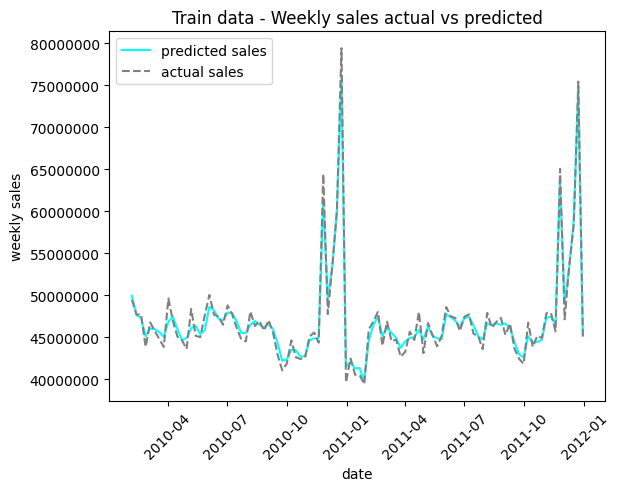

In [10]:
sns.lineplot(data=train, x='Date', y=train.groupby(['Date'])['Predicted_Sales'].transform('sum'), 
             label='predicted sales', errorbar=None,
             color='cyan')
sns.lineplot(data=train, x='Date', y=train.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', errorbar=None,
             color='grey', linestyle='--')
plt.title('Train data - Weekly sales actual vs predicted')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend();

As one can see in the above chart, the blue line visualising the predicted target values is nearly covered by the grey dashed line showing actual values.

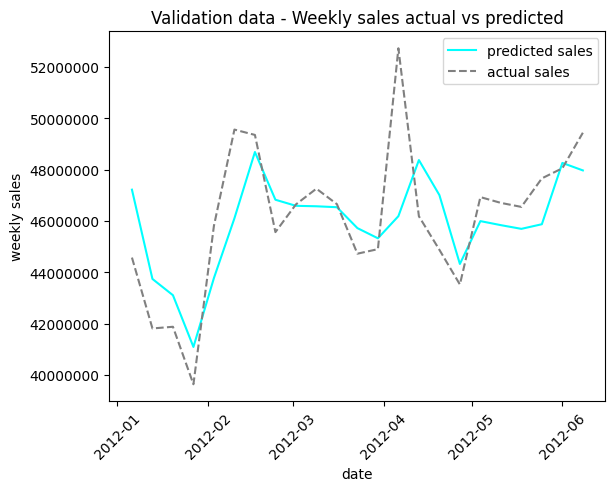

In [11]:
sns.lineplot(data=validation, x='Date', y=validation.groupby(['Date'])['Predicted_Sales'].transform('sum'),
             label='predicted sales', errorbar=None,
             color='cyan')
sns.lineplot(data=validation, x='Date', y=validation.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', errorbar=None,
             color='grey', linestyle='--')
plt.title('Validation data - Weekly sales actual vs predicted')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend();

In validation data the predicted sales are still predicting well with a short time lag. The large peek isn't well covered by the model.

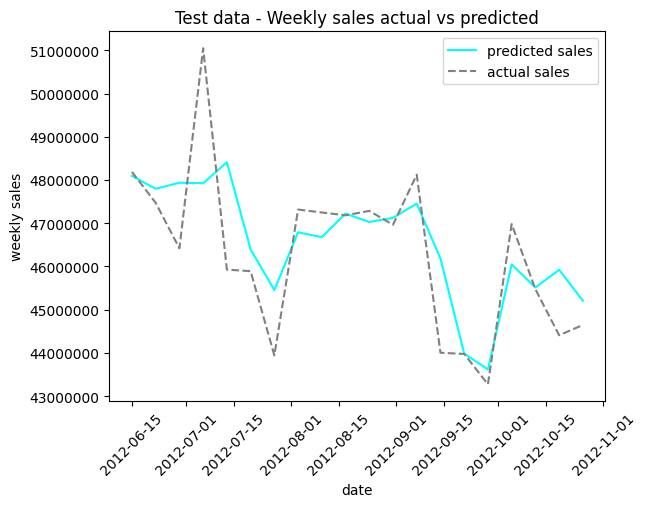

In [12]:
sns.lineplot(data=test, x='Date', y=test.groupby(['Date'])['Predicted_Sales'].transform('sum'),
             label='predicted sales', errorbar=None,
             color='cyan')
sns.lineplot(data=test, x='Date', y=test.groupby(['Date'])['Weekly_Sales'].transform('sum'), 
             label ='actual sales', errorbar=None,
             color='grey', linestyle='--')
plt.title('Test data - Weekly sales actual vs predicted')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend();

Same in the test data. Again the model predicts all in all well with a short time lag, but it has difficulties to predict the extreme outliers.

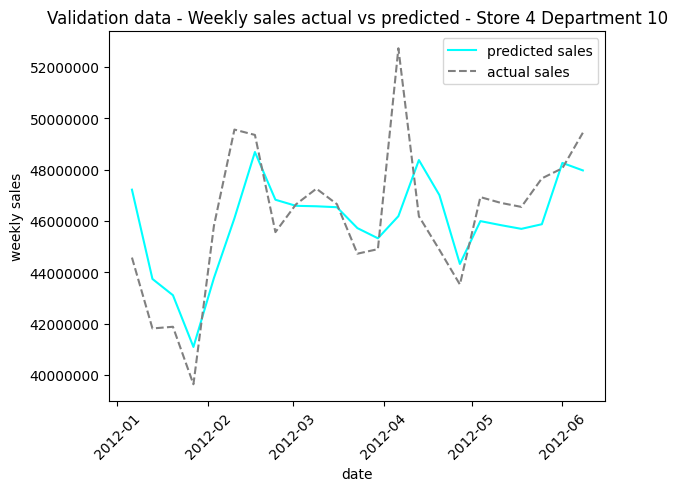

In [13]:
sns.lineplot(data=validation.query('Store==4 and Dept==10'), 
             x='Date', y=validation.groupby(['Date'])['Predicted_Sales'].transform('sum'), 
             errorbar=None, label='predicted sales', color='cyan')
sns.lineplot(data=validation.query('Store==4 and Dept==10'), 
             x='Date', y=validation.groupby(['Date'])['Weekly_Sales'].transform('sum'), errorbar=None,
             label ='actual sales', color='grey', linestyle='--')
plt.title('Validation data - Weekly sales actual vs predicted - Store 4 Department 10')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend();

Here we just see an example of the prediction for a specific Store and Department. The general effect can be found on the micro level as well.

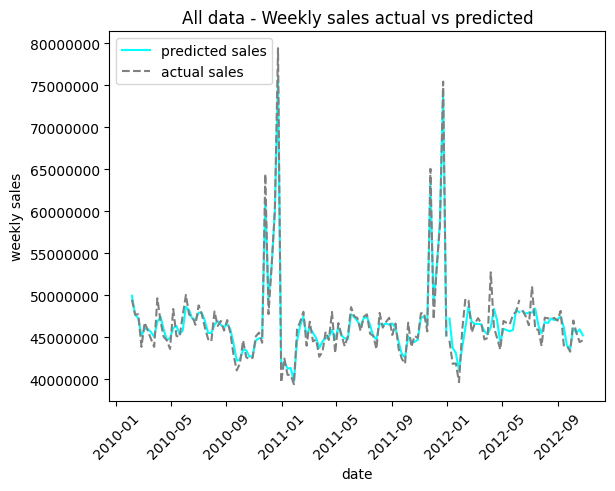

In [14]:
sns.lineplot(data=train, x='Date', y=train.groupby(['Date'])['Predicted_Sales'].transform('sum'), errorbar=None,
             label='predicted sales', color='cyan')
sns.lineplot(data=train, x='Date', y=train.groupby(['Date'])['Weekly_Sales'].transform('sum'), errorbar=None,
             label ='actual sales', color='grey', linestyle='--')
sns.lineplot(data=validation, x='Date', y=validation.groupby(['Date'])['Predicted_Sales'].transform('sum'), errorbar=None,
             color='cyan')
sns.lineplot(data=validation, x='Date', y=validation.groupby(['Date'])['Weekly_Sales'].transform('sum'), errorbar=None,
             color='grey', linestyle='--')
sns.lineplot(data=test, x='Date', y=test.groupby(['Date'])['Predicted_Sales'].transform('sum'), errorbar=None,
            color='cyan')
sns.lineplot(data=test, x='Date', y=test.groupby(['Date'])['Weekly_Sales'].transform('sum'), errorbar=None,
            color='grey', linestyle='--')
plt.title('All data - Weekly sales actual vs predicted')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.legend();

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis</div>
<br>
First defining a function for error analysis

In [15]:
def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Train</div>

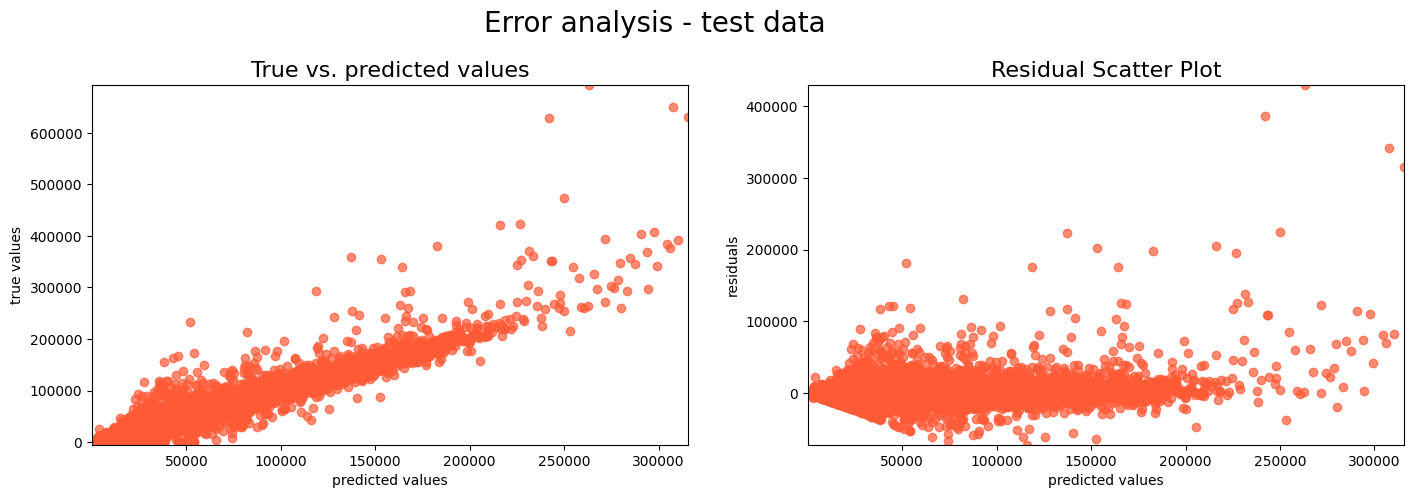

In [16]:
error_analysis(y_train, y_pred_train)
plt.suptitle('Error analysis - test data', fontsize=20)
plt.subplots_adjust(top=0.83);

Most of the values of the Residual Scatter Plot are scattered around zero. But what we can also see here, that there are some outliers, which means data points with large residuals, that could significantly influence the model. In the next step we want to find out more about the patterns of these outliers.

In [21]:
train['Residuals'] = train.Weekly_Sales - train.Predicted_Sales
train.query('Residuals >= 20000 or Residuals <= -20000')


,Store,Dept,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Size,Year,Temp_Celsius,...,Christmas,Shifted_Rolling_Avg_4,Shifted_Rolling_Avg_5,Shifted_Rolling_Avg_6,Shifted_Rolling_Avg_7,IsHoliday_True,Type_B,Type_C,Predicted_Sales,Residuals
594,1,7,2010-12-24,166697.72,2.886,211.405122,7.838,151315,2010,11.29,...,0,96198.12,63896.89,72635.06,4159.51,0,0,0,139247.674484,27450.045516
1148,1,13,2010-02-05,41969.29,2.572,211.096358,8.106,151315,2010,5.73,...,0,8658.41,10830.48,10037.09,9964.78,0,0,0,20295.643277,21673.646723
3448,1,38,2010-02-05,115564.35,2.572,211.096358,8.106,151315,2010,5.73,...,0,2566.42,2483.49,2466.90,2751.27,0,0,0,47892.028876,67672.321124
3460,1,38,2010-04-30,127811.89,2.780,210.389546,7.808,151315,2010,19.67,...,0,87205.88,77602.00,101566.87,1943.14,0,0,0,99871.285194,27940.604806
3539,1,38,2011-11-04,115249.43,3.332,217.837382,7.866,151315,2011,12.77,...,0,67148.18,76702.90,83059.47,77547.67,0,0,0,91377.399289,23872.030711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264594,45,72,2010-12-24,136297.96,3.141,182.544590,8.724,118221,2010,-0.78,...,0,69463.94,49028.46,240758.86,3071.95,0,1,0,115542.627852,20755.332148
265548,45,92,2010-02-05,68203.08,2.784,181.871190,8.992,118221,2010,-2.61,...,0,16330.84,15985.60,16221.11,17256.02,0,1,0,28897.202187,39305.877813
265648,45,93,2010-02-05,4002.34,2.784,181.871190,8.992,118221,2010,-2.61,...,0,54608.75,48108.38,50301.74,53299.02,0,1,0,33391.559464,-29389.219464
265748,45,95,2010-02-05,63833.63,2.784,181.871190,8.992,118221,2010,-2.61,...,0,2487.80,2270.50,2807.14,1640.50,0,1,0,31744.793176,32088.836824


Further investigation would be something to do in future work.

<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Validation</div>

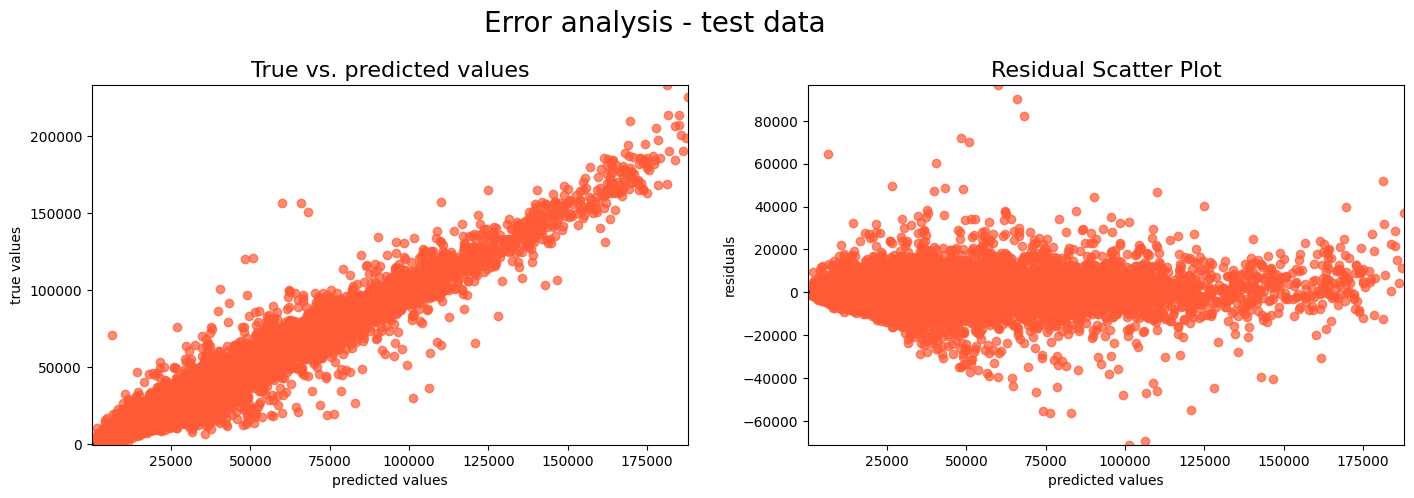

In [27]:
error_analysis(y_validation, y_pred_validation)
plt.suptitle('Error analysis - test data', fontsize=20)
plt.subplots_adjust(top=0.83);

Also in this plot, the values above and below 20.000 would be worse to investigate more in future work.

In [28]:
validation['Residuals'] = validation.Weekly_Sales - validation.Predicted_Sales
validation.query('Residuals >= 5000 or Residuals <= -5000')

,Store,Dept,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Size,Year,Temp_Celsius,...,Christmas,Shifted_Rolling_Avg_4,Shifted_Rolling_Avg_5,Shifted_Rolling_Avg_6,Shifted_Rolling_Avg_7,IsHoliday_True,Type_B,Type_C,Predicted_Sales,Residuals
0,1,1,2012-01-06,16567.69,3.157,219.714258,7.348,151315,2012,9.45,...,0,23350.88,46788.75,33305.92,15984.24,0,0,0,24254.091572,-7686.401572
5,1,1,2012-02-10,36988.49,3.409,220.265178,7.348,151315,2012,8.90,...,0,23510.49,18378.16,16894.40,37887.17,1,0,0,31748.095778,5240.394222
6,1,1,2012-02-17,54060.10,3.510,220.425759,7.348,151315,2012,7.40,...,0,36988.49,23510.49,18365.10,46845.87,0,0,0,45742.556962,8317.543038
7,1,1,2012-02-24,20124.22,3.555,220.636902,7.348,151315,2012,14.03,...,0,54060.10,36988.49,18378.16,19363.83,0,0,0,49056.069392,-28931.849392
12,1,1,2012-03-30,28952.86,3.845,221.361012,7.348,151315,2012,19.78,...,0,22107.70,22366.88,20113.03,20398.09,0,0,0,23085.357544,5867.502456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61099,45,92,2012-03-23,46417.71,3.900,190.536321,8.424,118221,2012,15.25,...,0,53375.48,55215.91,50250.44,45032.41,0,1,0,51695.744086,-5278.034086
61101,45,92,2012-04-06,55020.89,3.996,190.685171,8.567,118221,2012,9.85,...,0,46968.14,46417.71,55215.91,48868.54,0,1,0,50012.134380,5008.755620
61109,45,92,2012-06-01,42882.18,3.742,191.009171,8.567,118221,2012,23.60,...,0,47225.79,45908.30,51091.55,44751.00,0,1,0,48003.892002,-5121.712002
61146,45,95,2012-03-30,46430.99,3.953,190.610746,8.424,118221,2012,10.02,...,0,49554.61,52182.65,51125.95,52112.96,0,1,0,51829.407279,-5398.417279


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Error Analysis Test</div>

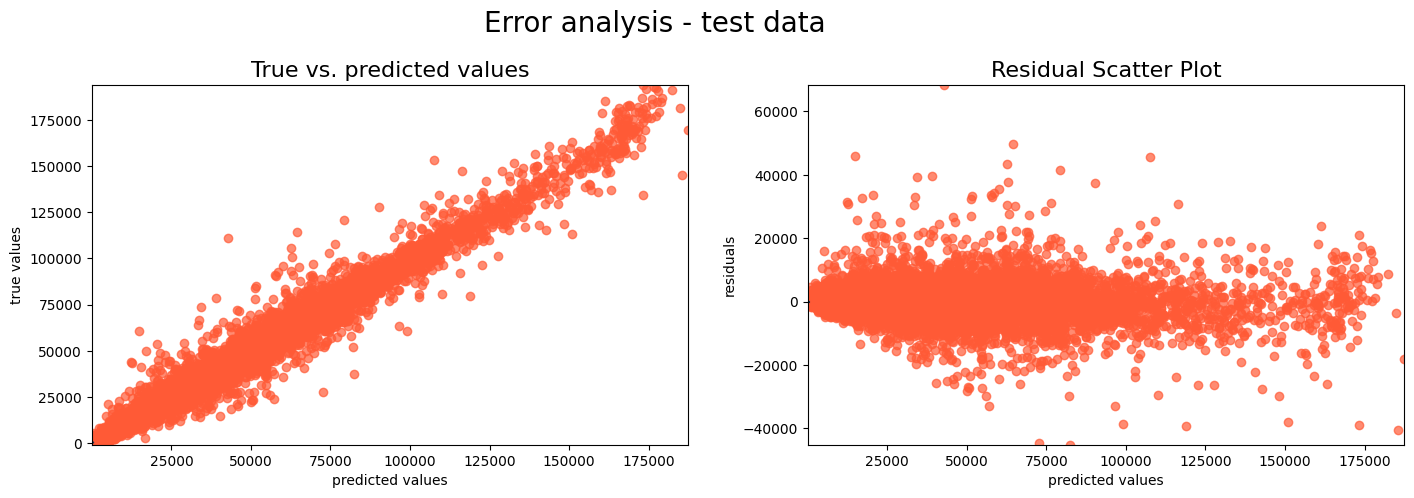

In [29]:
error_analysis(y_test, y_pred_test)
plt.suptitle('Error analysis - test data', fontsize=20)
plt.subplots_adjust(top=0.83);

In [30]:
test['Residuals'] = test.Weekly_Sales - test.Predicted_Sales
test.query('Residuals >= 4000 or Residuals <= -4000')

,Store,Dept,Date,Weekly_Sales,Fuel_Price,CPI,Unemployment,Size,Year,Temp_Celsius,...,Christmas,Shifted_Rolling_Avg_4,Shifted_Rolling_Avg_5,Shifted_Rolling_Avg_6,Shifted_Rolling_Avg_7,IsHoliday_True,Type_B,Type_C,Predicted_Sales,Residuals
45,1,3,2012-07-20,20126.95,3.311,221.932727,6.908,151315,2012,26.90,...,0,13126.15,8473.71,7301.41,16069.50,0,0,0,15631.634920,4495.315080
48,1,3,2012-08-10,28257.30,3.494,221.958433,6.908,151315,2012,29.47,...,0,30331.69,22716.70,13126.15,32148.93,0,0,0,33975.087009,-5717.787009
49,1,3,2012-08-17,31905.97,3.571,222.038411,6.908,151315,2012,29.36,...,0,28257.30,30331.69,20126.95,41603.11,0,0,0,36037.886353,-4131.916353
51,1,3,2012-08-31,50701.30,3.638,222.305480,6.908,151315,2012,26.94,...,0,43712.78,31905.97,30331.69,19604.47,0,0,0,36041.196259,14660.103741
52,1,3,2012-09-07,18368.51,3.730,222.439015,6.908,151315,2012,28.87,...,0,50701.30,43712.78,28257.30,12778.28,1,0,0,37403.719911,-19035.209911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53165,45,95,2012-07-20,53136.34,3.567,191.167043,8.684,118221,2012,26.05,...,0,55919.21,62606.75,56624.74,62049.70,0,1,0,59205.058322,-6068.718322
53170,45,95,2012-08-24,51221.99,3.834,191.344887,8.684,118221,2012,22.57,...,0,53108.04,54892.83,51943.79,75204.77,0,1,0,57323.451857,-6101.461857
53177,45,95,2012-10-12,49334.77,4.000,192.327265,8.667,118221,2012,12.48,...,0,50241.01,49380.11,53711.96,55638.35,0,1,0,54117.566312,-4782.796312
53178,45,95,2012-10-19,48434.97,3.969,192.330854,8.667,118221,2012,13.59,...,0,49334.77,50241.01,54160.50,51719.98,0,1,0,52883.115148,-4448.145148


<div style="background-color: lightblue; color: black; padding: 10px; font-weight: bold; font-size: 15px;">Merge validation and test</div>

In [31]:
validation_and_test = pd.concat([validation, test], axis=0)

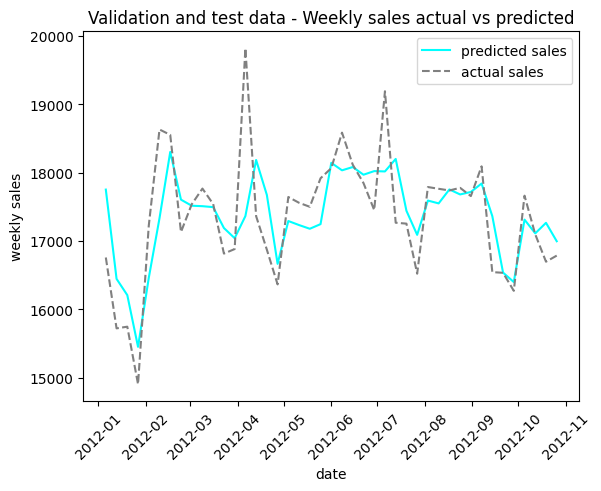

In [32]:
sns.lineplot(data=validation_and_test, x='Date', y='Predicted_Sales', errorbar=None,
             label='predicted sales', color='cyan')
sns.lineplot(data=validation_and_test, x='Date', y='Weekly_Sales', errorbar=None,
             label ='actual sales', color='grey', linestyle='--')
plt.title('Validation and test data - Weekly sales actual vs predicted')
plt.ylabel('weekly sales')
plt.xlabel('date')
plt.xticks(rotation=45)
plt.legend();